In [1]:
from pyradiosky import SkyModel, utils
import numpy as np
from astropy.table import Table, setdiff, QTable
from astropy.utils.diff import report_diff_values
from astropy.io import fits
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import psutil
import erfa
import csv
sm = SkyModel()

ruby_catalog = sm.from_fhd_catalog("/Users/Kiana1/uwradcos/FHD/catalog_data/GLEAM_v2_plus_rlb2019.sav",
                                  expand_extended = True)
gleam_catalog = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "subband", with_error = True)
gleam_spectral_index = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "spectral_index", with_error = True)

In [46]:
def log_linear_fit(freqs, fit_data, stokes_error, dec, detect_outlier = False):
    ## Compute combined error, fit logged data to linear polynomial, calculate chi2 residual
    # Calculate coord-based portion of error
    if (dec >= 18.5) or (dec <= -72):
        loc_error = fit_data * .03
    else:
        loc_error = fit_data * .02
    
    # Compute total error and weight for the polyfit
    total_error = np.sqrt(loc_error**2 + stokes_error**2)
    weight = np.log10(1 / total_error)
    
    # Take logs of data and freqs for polyfit
    fit_data_log = np.log10(fit_data)
    freqs_log = np.log10(freqs)
    all_freqs_log = np.log10(gleam_catalog.freq_array.value)
    
    # Subset to freqs with no nans in vals or errors and do polyfit on only those freqs
    idx = np.isfinite(freqs_log) & np.isfinite(fit_data_log) & np.isfinite(weight)
    # coeffs is a pair of numbers (b, m) corresponding to the equation y=b+mx
    coeffs = poly.polyfit(freqs_log[idx], fit_data_log[idx], w = weight[idx], deg=1)
    
    # Use coeffs to generate modeled vals at only freqs that were used to make coeffs
    fit_log = poly.polyval(freqs_log[idx], coeffs)
    fitted_data = 10**fit_log
    
    # use coefficients to generate modeled vals at all 20 freqs
    full_fit_log = poly.polyval(all_freqs_log, coeffs)
    all_freqs_fitted_data = 10**full_fit_log
    
    #compute chi2 value
    variance = total_error[idx]**2
    residual = fit_data[idx] - fitted_data
    chi2 = sum((residual**2) / variance)
    chi2_residual = chi2 / (len(freqs[idx]) - 2)
    
    fitted_freqs = freqs[idx]
    fit_data_selected = fit_data[idx]
    
    original_parameters = np.array([[float("NaN")]])
    # Outlier detection reruns fit without greatest outlier
    if detect_outlier == True:
        idx_outlier = np.argmax(abs(residual))
        
        # create datasets with outlier removed
        log_data_ol = np.delete(fit_data_log[idx], idx_outlier)
        log_freq_ol = np.delete(freqs_log[idx], idx_outlier)
        weight_ol = np.delete(weight[idx], idx_outlier)
        
        #fit without the outlier
        coeffs_ol = poly.polyfit(log_freq_ol, log_data_ol, w = weight_ol, deg=1)
        
        fit_log_ol = poly.polyval(log_freq_ol, coeffs_ol)
        fitted_data_ol = 10**fit_log_ol
        full_fit_log_ol = poly.polyval(all_freqs_log, coeffs_ol)
        all_freqs_fitted_data_ol = 10**full_fit_log_ol
        
        # compute chi2 using this new fit
        variance_ol = np.delete(total_error[idx], idx_outlier)**2
        residual_ol = np.delete(fit_data[idx], idx_outlier) - np.delete(fitted_data, idx_outlier)
        
        chi2_ol = sum((residual_ol**2) / variance_ol)
        chi2_residual_ol = chi2_ol / (len(np.delete(freqs[idx], idx_outlier)) - 2)
        

        # see if fit has improved
        if chi2_residual_ol < chi2_residual / 2.6:
            
            original_parameters = np.array([coeffs, chi2_residual, fitted_data, all_freqs_fitted_data, fitted_freqs, fit_data_selected], dtype=object)
            
            #reassign values with outlier removed version of fit
            chi2_residual = chi2_residual_ol
            coeffs = coeffs_ol
            fitted_data = fitted_data_ol
            all_freqs_fitted_data = all_freqs_fitted_data_ol
            fitted_freqs = np.delete(freqs[idx], idx_outlier)
            fit_data_selected = np.delete(fit_data[idx], idx_outlier)
    
    return(coeffs, chi2_residual, fitted_data, all_freqs_fitted_data, fitted_freqs, fit_data_selected, original_parameters)

## COMPUTE FITS FOR SOURCES
# Initialize arrays and lists and stuff
source_dict = {}
bad_chi2 = []
averages = []
fit_averages = []
problem_objs = []


# Separate all rows that contain nans
for source in np.arange(gleam_catalog.Ncomponents):
#for source in np.arange(10):
    fit_data = gleam_catalog.stokes.value[0,:,source]
    dec = gleam_catalog.dec.value[source]
    freqs = gleam_catalog.freq_array.value
    stokes_error = gleam_catalog.stokes_error.value[0,:,source]
    
    mean_adj_data = (fit_data - np.nanmean(fit_data)) / np.nanmean(fit_data)
    diff = np.diff(mean_adj_data)
    variance = np.nanvar(diff)
    
    averages.append(np.average(fit_data))
    out2 = np.array([[float("NaN")], [float("NaN")], [float("NaN")], [float("NaN")]])
    out3 = np.array([[float("NaN")], [float("NaN")], [float("NaN")], [float("NaN")]])

    ### find sources that have missing values in only one of error and vals ###
    source_probs = []
    for i in range(len(fit_data)):
        if np.isnan(fit_data[i]):
            if ~np.isnan(stokes_error[i]) and not source_probs:
                source_probs.append([fit_data, stokes_error])
        else:
            if np.isnan(stokes_error[i]) and not source_probs:
                source_probs.append([fit_data, stokes_error])
          
    # only include if there WAS a problem, exclude from rest of fit
    if source_probs:
        problem_objs.append([source, gleam_catalog.ra.value[source], gleam_catalog.dec.value[source], source_probs])
        continue
    
    ### remove negative data by turning into nans before fitting.
    fit_data[fit_data < 0] = np.nan
    indices = np.argwhere(~np.isnan(fit_data)).flatten()
    
    if np.all(np.isnan(fit_data)):
        continue

    out1 = log_linear_fit(freqs, fit_data, stokes_error, dec, detect_outlier = True)
    out = out1
    # if chi2_residual is >=1.93, fit again
    if out[1] >= 1.93:
        if len(fit_data[indices]) >= 8:
            half_freqs = freqs[indices[:int(len(indices) / 2)]]
            fit_data_half = fit_data[indices[:int(len(indices) / 2)]]
            error_half = stokes_error[indices[:int(len(indices) / 2)]]
        
            out2 = log_linear_fit(half_freqs, fit_data_half, error_half, dec)
            out = out2
            
            # if second fit isn't good try again
            if out[1] >= 1.93:
                # If 8+ freqs remain after halving, fit on bottom 1/4
                if len(half_freqs) >= 8:
                    qt_freqs = half_freqs[:int(len(half_freqs) / 2)]
                    fit_data_qt = fit_data_half[:int(len(half_freqs) / 2)]
                    error_qt = error_half[:int(len(half_freqs) / 2)]
                    
                    out3 = log_linear_fit(qt_freqs, fit_data_qt, error_qt, dec)
                    out = out3
                    
                # If there are <8 total non-nan frequencies, fit on bottom 4
                else:
                    bottom_freqs = freqs[indices[:4]]
                    fit_data_bottom = fit_data[indices[:4]]
                    error_bottom = stokes_error[indices[:4]]
            
                    out3 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)  
                    out = out3
            
        else:
            # run fit on bottom 4 non-nan-value frequencies if <8 total non-nan-value freqs
            bottom_freqs = freqs[indices[:4]]
            fit_data_bottom = fit_data[indices[:4]]
            error_bottom = stokes_error[indices[:4]]
            
            out2 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)
            out = out2

    # if chi2_residual is still large after all iterations
    if out[1] >= 1.93:
        bad_chi2.append([source, out1[3], out2[3], out3[3], out1[1], out2[1], out3[1]])
    
    fit_averages.append(np.average(out[3]))
    # These are the things contained in out1, out2, out3:
    # coeffs, chi2_residual, fitted_data, all_freqs_fitted_data, fitted_freqs, fit_data_selected, original_parameters
    
    # Create dict with final vals
    source_vars = {
        "ra": gleam_catalog.ra.value[source],
        "dec": dec,
        "coefficients": out[0],
        "chi2_residual": out[1],
        "prev_chi2_residuals": [out1[3], out2[3], out3[3], out1[1], out2[1], out3[1], out1[2], out2[2], out3[2]],
        "fitted_data": out[2],
        "all_freqs_fitted_data": out[3],
        "freqs": freqs,
        "freqs_used_for_fit": out[4],
        "data_used_for_fit": out[5],
        "pre_outlier_removal_output": out[6],
        "variance": variance
    }
    # source_dict is a dict of dicts
    source_dict[source] = source_vars

Mean of empty slice
Degrees of freedom <= 0 for slice.
divide by zero encountered in log10


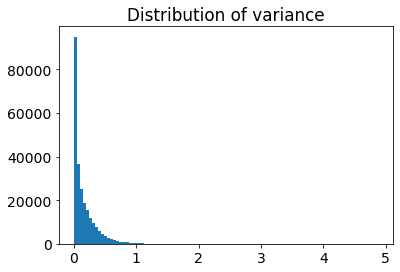

In [104]:
# plot variance
v = []
for i in source_dict:
    if i in source_dict:
        v.append(source_dict[i]['variance'])
        
v2 = [x for x in v]# if x <= 2]
plt.hist(v2, bins = 100)
plt.title("Distribution of variance")
plt.savefig("/Users/Kiana1/uwradcos/plots/variance_hist_og.png")

No handles with labels found to put in legend.


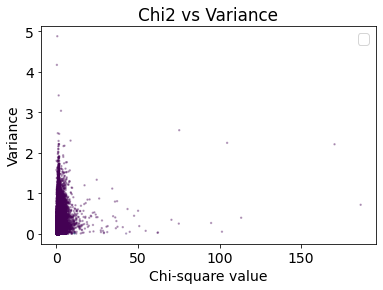

In [61]:
chi2 = []
v = []
max_bright = []

for i in source_dict:
    if i in source_dict:
        v.append(source_dict[i]['variance'])
        chi2.append(source_dict[i]['chi2_residual'])
        max_bright.append(np.nanmax(source_dict[i]['data_used_for_fit']))

plt.scatter(chi2, v, c=max_bright, s = 2, alpha = .3)
plt.legend()
plt.xlabel("Chi-square value")
plt.ylabel("Variance")
plt.title("Chi2 vs Variance")
plt.savefig("/Users/Kiana1/uwradcos/plots/chi2_variance_scatter_og.png")

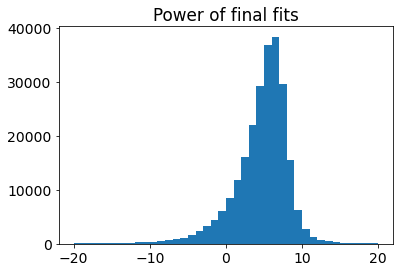

In [75]:
power = []
for i in source_dict:
    if i in source_dict:
        power.append(source_dict[i]['coefficients'][0])
power2 = [x for x in power if -20 < x <= 20]
plt.hist(power2, bins=40)
plt.title("Power of final fits")
plt.savefig("/Users/Kiana1/uwradcos/plots/final_power_hist_og.png")

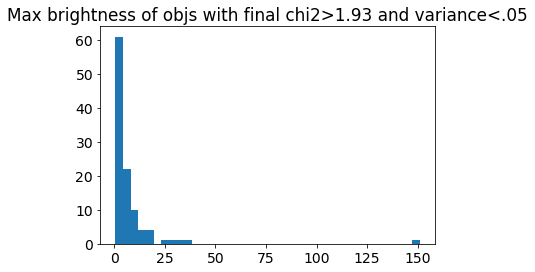

In [102]:
bad_objs = []
for i in source_dict:
    if i in source_dict:
        if source_dict[i]['chi2_residual'] > 1.93 and source_dict[i]['variance'] < .01:
            bad_objs.append(np.nanmax(source_dict[i]['data_used_for_fit']))

plt.hist(bad_objs, bins = 40)
plt.title("Max brightness of objs with final chi2>1.93 and variance<.05")
plt.savefig("/Users/Kiana1/uwradcos/plots/bad_chi2_variance_hist_og.png")

In [90]:
bad_objs[0]

[42.78532529266144, 0.009717053297436239, 32.385719]

In [ ]:
# Create csv of results of fitting.
fit_output = pd.DataFrame(source_dict).T
fit_output.to_csv("/Users/Kiana1/uwradcos/GleamPlusFullSpectrum/misc/gleam_catalog_fits.csv")

In [ ]:
##print(np.setdiff1d(source_dict[3]["prev_chi2_residuals"][2],source_dict[3]["prev_chi2_residuals"][7]))
#print(source_dict[3]["prev_chi2_residuals"][7])
print(len(source_dict[3]["freqs_used_for_fit"]))
print(gleam_catalog.stokes_error.value[0, 0:len(source_dict[3]["freqs_used_for_fit"]), 3])

In [4]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import itertools

def grouper(n, iterable):
    args = [iter(iterable)] * n
    #print(args)
    return ([e for e in t if e != None] for t in itertools.zip_longest(*args))

# Plot fits that have more than one fit attempt
def plotFits(gleam_catalog, source_dict, savefig=False, Nsources=9,
             saveloc="/Users/Kiana1/uwradcos/plots/compare_outlier_spectrums"):
    #get sources ordered by max power of points used for final fit
    ordered_power = []
    for i in np.arange(max(source_dict)):
        if i in source_dict:
            # skip objs that found good fit first time
            if np.isnan(source_dict[i]['prev_chi2_residuals'][1][0]):
                continue
            # skip objs where max val is <100mJ
            if np.nanmax(source_dict[i]['data_used_for_fit']) < .1:
                continue
                
            source_max = np.nanmax(source_dict[i]['data_used_for_fit'])
            ordered_power.append([source_max, i])
    ordered_power = sorted(ordered_power, key=lambda x: x[0], reverse = True)
    
    if Nsources == "all":
        Nsources = len(ordered_power)
    
    #number of pages necessary
    grouped_sources = grouper(9, range(Nsources))

    for j in list(grouped_sources):
        page = int(max(j) / 9)
        nsources = max(j)+1 / (page + 1)

        fig = plt.figure(figsize=(28,20))
        nrows = 3
        gs = gridspec.GridSpec(3*nrows, 3, height_ratios=np.tile([1,0.4,0.25],nrows))
        plt.subplots_adjust(hspace=.0)
        
        elements = []
        for page_idx,i in enumerate(j):
            plots = []
            fit = plt.subplot(gs[int((page_idx//3)*9 + page_idx%3)])
            
            source_num = ordered_power[i][1]
            freqs = source_dict[source_num]['freqs'] / 1000000

            ref_freq = gleam_spectral_index.reference_frequency.value[source_num] / 1000000
            gleam_fit = gleam_spectral_index.stokes[0,0,source_num]*(freqs/ref_freq)**(gleam_spectral_index.spectral_index[source_num])
            plots.append('fit.plot(freqs, gleam_fit, label="gleam fit", linestyle = ":", color = "#7299FF")')

            # Plot raw data
            raw_data = gleam_catalog.stokes.value[0,:,source_num]
            raw_freqs = gleam_catalog.freq_array.value / 1000000
            stokes_error = gleam_catalog.stokes_error.value[0,:,source_num]
            plots.append('fit.errorbar(raw_freqs, raw_data, yerr = stokes_error, fmt = "o", label = "raw data", color = "#FFC950")')
            
            # make raw data points used in final fit a different color
            raw_data_fitted = source_dict[source_num]["data_used_for_fit"]
            raw_freqs_fitted = source_dict[source_num]["freqs_used_for_fit"] / 1000000
            plots.append('fit.errorbar(raw_freqs_fitted, raw_data_fitted, yerr = gleam_catalog.stokes_error.value[0, 0:len(source_dict[source_num]["freqs_used_for_fit"]), source_num], fmt = "o", label = "raw data", color = "#845B00")')
            
            # Calculate deviation from the mean, compute variance of deviation
            mean_adj_data = (raw_data - np.nanmean(raw_data)) / np.nanmean(raw_data)
            diff = np.diff(mean_adj_data)
            variance = np.nanvar(diff)
            
            #plot full initial fit, regardless of whether an outlier was removed
            full_fit_post_outlier = source_dict[source_num]['prev_chi2_residuals'][0]
            plots.append('fit.plot(freqs, full_fit_post_outlier, label = "full fit", color = "#378A00")')

            text_content = [r'$\mathbf{Full\/Fit\/\chi^2=%.2f}$' % (source_dict[source_num]['prev_chi2_residuals'][3])]

            residual = raw_data / full_fit_post_outlier

            # Add item to legend if it doesn't already exist from prev plots on the page
            if 'Line2D([0], [0], linestyle = ":", color = "#7299FF", label="gleam fit")' not in elements: elements.append('Line2D([0], [0], linestyle = ":", color = "#7299FF", label="gleam fit")')
            if 'Line2D([0], [0], marker = "o", markersize = 15,  color = "#FFC950", label = "raw data")' not in elements: elements.append('Line2D([0], [0], marker = "o", markersize = 15,  color = "#FFC950", label = "raw data")')
            if 'Line2D([0], [0], marker = "o", markersize = 15,  color = "#845B00", label = "raw data used")' not in elements: elements.append('Line2D([0], [0], marker = "o", markersize = 15,  color = "#845B00", label = "raw data used")')
            if 'Line2D([0], [0], color = "#378A00", label = "full fit")' not in elements: elements.append('Line2D([0], [0], color = "#378A00", label = "full fit")')

            # these are the data for the first fit whether or not there's an outlier
            post_outlier_freqs = source_dict[source_num]['freqs_used_for_fit'] / 1000000   
            post_outlier_flux = source_dict[source_num]['fitted_data']
            
            # if there is an outlier, include outlier lines
            if ~np.isnan(source_dict[source_num]['pre_outlier_removal_output'][0][0]):

                full_fit_pre_outlier = source_dict[source_num]['pre_outlier_removal_output'][3]

                pre_outlier_freqs = source_dict[source_num]['pre_outlier_removal_output'][4] / 1000000
                pre_outlier_flux = source_dict[source_num]['pre_outlier_removal_output'][2]

                outlier_freq = np.setdiff1d(list(pre_outlier_freqs),list(post_outlier_freqs))
                outlier_flux = gleam_catalog.stokes.value[0,gleam_catalog.freq_array.value == outlier_freq * 1000000, source_num]

                # data plots if there was an outlier
                plots.append('fit.plot(freqs, full_fit_pre_outlier, linestyle = "--", label = "full fit pre-outlier removal", color = "#002940")')
                plots.append('fit.scatter(outlier_freq, outlier_flux, label = "outlier", color = "#9A00FF")')

                if 'Line2D([0], [0], color = "#002940", linestyle = "--" label = "pre-outlier removal")' not in elements: elements.append('Line2D([0], [0], color = "#002940", linestyle = "--", label = "pre-outlier removal")')
                if 'Line2D([0], [0], marker = "o", markersize = 13, color = "#9A00FF", label = "outlier")' not in elements: elements.append('Line2D([0], [0], marker = "o", markersize = 13, color = "#9A00FF", label = "outlier")')

            props_var = dict(boxstyle = "round", facecolor = "wheat", alpha = .5)
            textstr_var = 'var {:.2e}'.format(variance)
            
            ## PLOT FITS THAT EXIST FOR SOURCE ##
            # Plot half frequencies fit
            if ~np.isnan(source_dict[source_num]['prev_chi2_residuals'][1][0]):
                half_fit = source_dict[source_num]['prev_chi2_residuals'][1]
                plots.append('fit.plot(freqs, half_fit, label = "half fit", color = "#BD1C6B")')

                text_content = [r'$Full\/Fit\/\chi^2=%.2f$' % (source_dict[source_num]['prev_chi2_residuals'][3]),
                    r'$\mathbf{Half\/Fit\/\chi^2=%.2f}$' % (source_dict[source_num]['prev_chi2_residuals'][4])]

                residual = abs(raw_data / half_fit)
                if 'Line2D([0], [0], color = "#BD1C6B", label = "half fit")' not in elements: elements.append('Line2D([0], [0], color = "#BD1C6B", label = "half fit")')
                
                fit.text(0.97, 0.68, textstr_var, horizontalalignment='right', verticalalignment='top', transform=fit.transAxes, bbox = props_var)
            
                # Plot quarter frequencies fit
                if ~np.isnan(source_dict[source_num]['prev_chi2_residuals'][2][0]):
                    quarter_fit = source_dict[source_num]['prev_chi2_residuals'][2]
                    
                    # if no good fit is found change axes color to red
                    if source_dict[source_num]['prev_chi2_residuals'][5] >=1.93:
                        plots.append('fit.spines["left"].set_color("red")')
                        plots.append('fit.tick_params(axis="y", colors="red")')
                        plots.append('resid.spines["bottom"].set_color("red")')
                        plots.append('resid.spines["left"].set_color("red")')
                        plots.append('resid.tick_params(axis="y", colors="red")')
                        plots.append('resid.tick_params(axis="x", colors="red")')
                        plots.append('fit.patch.set_facecolor("#FFE4E4")')
                        plots.append('resid.patch.set_facecolor("#FFE4E4")')
                        
                    plots.append('fit.plot(freqs, quarter_fit, label = "quarter fit", color = "#785EF0")')

                    text_content = [r'$Full\/Fit\/ \chi^2=%.2f$' % (source_dict[source_num]['prev_chi2_residuals'][3]),
                        r'$Half\/Fit\/\chi^2=%.2f$' % (source_dict[source_num]['prev_chi2_residuals'][4]),
                        r'$\mathbf{Quart\/Fit\/\chi^2=%.2f}$' % (source_dict[source_num]['prev_chi2_residuals'][5])]

                    residual = abs(raw_data / quarter_fit)
                    if 'Line2D([0], [0], color = "#785EF0", label = "quarter fit")' not in elements: elements.append('Line2D([0], [0], color = "#785EF0", label = "quarter fit")')
                    
                    for t in fit.texts: t.set_visible(False)
                    fit.text(0.97, 0.56, textstr_var, horizontalalignment='right', verticalalignment='top', transform=fit.transAxes, bbox = props_var)
            

            # floating box
            textstr = '\n'.join((text_content))
            props = dict(boxstyle = "round", facecolor = "wheat", alpha = .5)
            
            mpl.rcParams['font.size']=14
            fit.text(0.97, 0.95, textstr, horizontalalignment='right', verticalalignment='top', transform=fit.transAxes, bbox = props)
            fit.set_ylim([np.nanmin(gleam_catalog.stokes.value[0,:,source_num])*.9, np.nanmax(gleam_catalog.stokes.value[0,:,source_num]) * 1.2])
            fit.set_title("Source "+ str(source_num) + ", RA " + "{:.2f}".format(source_dict[source_num]['ra']) + ", Dec " + "{:.2f}".format(source_dict[source_num]['dec']), fontsize = 14)

            resid = plt.subplot(gs[int((page_idx//3)*9 + page_idx%3 + 3)])
            
            res = resid.scatter(freqs, residual, marker = "P", color = '#000000', label = "residual")
            res2 = resid.axhline(y=1, linestyle = "-")
            if 'Line2D([0], [0], marker = "P", markersize = 13, color = "#000000", label = "residual")' not in elements: elements.append('Line2D([0], [0], marker = "P", markersize = 13, color = "#000000", label = "residual")')
        
            # Make final fit line thicker
            index = plots[-1].find('color')
            plots[-1] = plots[-1][:index] + 'linewidth = 4, ' + plots[-1][index:]

            for n in plots:
                eval(n)
        
        elements_comp = []
        for p in elements:
            elements_comp.append(eval(p))
            
        fig.legend(handles = elements_comp,   # The line objects
               loc="center right",            # Position of legend
               borderaxespad=0.1,             # Small spacing around legend box
               title="Dataset",               
               fontsize = 12,
               title_fontsize = 14
               )
        fig.text(0.5, 0.1, 'Frequency (MHz)', ha='center', fontsize = 16)
        fig.text(0.08, 0.5, 'Flux (Jy)', va='center', rotation='vertical', fontsize = 16)
        fig.text(.35, .9, "Source fits that required multiple fits, brightest to dimmest, excluding <100mJ", fontsize = 16)
        if savefig == True:
            print(f'Saving to {saveloc + str(page)}.jpg')
            plt.savefig(saveloc + str(page) + '.jpg', format = 'jpg')
        plt.close()
    print('Done')
        
plotFits(gleam_catalog, source_dict, savefig=True, Nsources='all',
             saveloc="/Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim")

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim0.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim3.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim4.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim5.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim6.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim7.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim8.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim9.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim10.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim11.jpg
Saving to /Use

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim99.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim100.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim101.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim102.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim103.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim104.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim105.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim106.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim107.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim108.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim109.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim197.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim198.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim199.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim200.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim201.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim202.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim203.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim204.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim205.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim206.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim207.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim295.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim296.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim297.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim298.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim299.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim300.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim301.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim302.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim303.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim304.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim305.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim393.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim394.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim395.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim396.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim397.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim398.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim399.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim400.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim401.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim402.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim403.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim491.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim492.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim493.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim494.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim495.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim496.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim497.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim498.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim499.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim500.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim501.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim589.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim590.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim591.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim592.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim593.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim594.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim595.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim596.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim597.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim598.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim599.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim687.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim688.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim689.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim690.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim691.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim692.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim693.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim694.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim695.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim696.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim697.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim785.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim786.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim787.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim788.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim789.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim790.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim791.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim792.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim793.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim794.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim795.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim883.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim884.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim885.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim886.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim887.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim888.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim889.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim890.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim891.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim892.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim893.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim981.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim982.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim983.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim984.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim985.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim986.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim987.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim988.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim989.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim990.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim991.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1078.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1079.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1080.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1081.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1082.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1083.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1084.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1085.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1086.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1087.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1088.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1175.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1176.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1177.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1178.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1179.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1180.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1181.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1182.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1183.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1184.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1185.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1272.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1273.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1274.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1275.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1276.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1277.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1278.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1279.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1280.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1281.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1282.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1369.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1370.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1371.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1372.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1373.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1374.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1375.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1376.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1377.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1378.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1379.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1466.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1467.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1468.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1469.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1470.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1471.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1472.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1473.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1474.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1475.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1476.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1563.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1564.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1565.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1566.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1567.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1568.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1569.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1570.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1571.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1572.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1573.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1660.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1661.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1662.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1663.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1664.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1665.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1666.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1667.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1668.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1669.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1670.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1757.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1758.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1759.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1760.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1761.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1762.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1763.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1764.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1765.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1766.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1767.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1854.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1855.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1856.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1857.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1858.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1859.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1860.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1861.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1862.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1863.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1864.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1951.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1952.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1953.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1954.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1955.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1956.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1957.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1958.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1959.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1960.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim1961.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2048.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2049.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2050.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2051.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2052.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2053.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2054.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2055.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2056.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2057.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2058.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2145.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2146.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2147.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2148.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2149.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2150.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2151.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2152.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2153.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2154.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2155.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2242.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2243.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2244.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2245.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2246.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2247.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2248.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2249.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2250.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2251.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2252.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2339.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2340.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2341.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2342.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2343.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2344.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2345.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2346.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2347.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2348.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2349.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2436.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2437.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2438.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2439.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2440.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2441.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2442.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2443.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2444.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2445.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_bright_to_dim2446.jpg
Saving to /Users/Kiana1/uwradcos/plots/source_fits/source_fits_br

In [5]:
import os
from PIL import Image
from fpdf import FPDF
pdf = FPDF()
sdir = "/Users/Kiana1/uwradcos/plots/source_fits/"
w,h = 0,0

# Combining output files 
for i in range(1, 2516):
    fname = sdir + "source_fits_bright_to_dim%.1d.jpg" % i
    if os.path.exists(fname):
        if i == 1:
            cover = Image.open(fname)
            w,h = cover.size
            pdf = FPDF(unit = "pt", format = [w,h])
        image = fname
        pdf.add_page()
        pdf.image(image,0,0,w,h)
    else:
        print("File not found:", fname)
    print("processed %d" % i)
pdf.output("/Users/Kiana1/uwradcos/plots/source_fits/output_all.pdf", "F")
print("done")

processed 1
processed 2
processed 3
processed 4
processed 5
processed 6
processed 7
processed 8
processed 9
processed 10
processed 11
processed 12
processed 13
processed 14
processed 15
processed 16
processed 17
processed 18
processed 19
processed 20
processed 21
processed 22
processed 23
processed 24
processed 25
processed 26
processed 27
processed 28
processed 29
processed 30
processed 31
processed 32
processed 33
processed 34
processed 35
processed 36
processed 37
processed 38
processed 39
processed 40
processed 41
processed 42
processed 43
processed 44
processed 45
processed 46
processed 47
processed 48
processed 49
processed 50
processed 51
processed 52
processed 53
processed 54
processed 55
processed 56
processed 57
processed 58
processed 59
processed 60
processed 61
processed 62
processed 63
processed 64
processed 65
processed 66
processed 67
processed 68
processed 69
processed 70
processed 71
processed 72
processed 73
processed 74
processed 75
processed 76
processed 77
processe

processed 692
processed 693
processed 694
processed 695
processed 696
processed 697
processed 698
processed 699
processed 700
processed 701
processed 702
processed 703
processed 704
processed 705
processed 706
processed 707
processed 708
processed 709
processed 710
processed 711
processed 712
processed 713
processed 714
processed 715
processed 716
processed 717
processed 718
processed 719
processed 720
processed 721
processed 722
processed 723
processed 724
processed 725
processed 726
processed 727
processed 728
processed 729
processed 730
processed 731
processed 732
processed 733
processed 734
processed 735
processed 736
processed 737
processed 738
processed 739
processed 740
processed 741
processed 742
processed 743
processed 744
processed 745
processed 746
processed 747
processed 748
processed 749
processed 750
processed 751
processed 752
processed 753
processed 754
processed 755
processed 756
processed 757
processed 758
processed 759
processed 760
processed 761
processed 762
proces

processed 1383
processed 1384
processed 1385
processed 1386
processed 1387
processed 1388
processed 1389
processed 1390
processed 1391
processed 1392
processed 1393
processed 1394
processed 1395
processed 1396
processed 1397
processed 1398
processed 1399
processed 1400
processed 1401
processed 1402
processed 1403
processed 1404
processed 1405
processed 1406
processed 1407
processed 1408
processed 1409
processed 1410
processed 1411
processed 1412
processed 1413
processed 1414
processed 1415
processed 1416
processed 1417
processed 1418
processed 1419
processed 1420
processed 1421
processed 1422
processed 1423
processed 1424
processed 1425
processed 1426
processed 1427
processed 1428
processed 1429
processed 1430
processed 1431
processed 1432
processed 1433
processed 1434
processed 1435
processed 1436
processed 1437
processed 1438
processed 1439
processed 1440
processed 1441
processed 1442
processed 1443
processed 1444
processed 1445
processed 1446
processed 1447
processed 1448
processed 

processed 1958
processed 1959
processed 1960
processed 1961
processed 1962
processed 1963
processed 1964
processed 1965
processed 1966
processed 1967
processed 1968
processed 1969
processed 1970
processed 1971
processed 1972
processed 1973
processed 1974
processed 1975
processed 1976
processed 1977
processed 1978
processed 1979
processed 1980
processed 1981
processed 1982
processed 1983
processed 1984
processed 1985
processed 1986
processed 1987
processed 1988
processed 1989
processed 1990
processed 1991
processed 1992
processed 1993
processed 1994
processed 1995
processed 1996
processed 1997
processed 1998
processed 1999
processed 2000
processed 2001
processed 2002
processed 2003
processed 2004
processed 2005
processed 2006
processed 2007
processed 2008
processed 2009
processed 2010
processed 2011
processed 2012
processed 2013
processed 2014
processed 2015
processed 2016
processed 2017
processed 2018
processed 2019
processed 2020
processed 2021
processed 2022
processed 2023
processed 

done


In [ ]:
# Compile all the sources with mismatching error and value data
problem_objs_missing_error = []
problem_objs_missing_vals = []
for source in np.arange(gleam_catalog.Ncomponents):
    
    fit_data = gleam_catalog.stokes.value[0,:,source]
    stokes_error = gleam_catalog.stokes_error.value[0,:,source]

    source_probs_missing_error = []
    source_probs_missing_vals = []
    for i in range(len(fit_data)):
        if np.isnan(fit_data[i]):
            if ~np.isnan(stokes_error[i]) and not source_probs_missing_vals:
                source_probs_missing_vals.append([[fit_data],[stokes_error]])
                #print(source, "fit data is nan and stokes is not nan. PROBLEM")
        else:
            if np.isnan(stokes_error[i]) and not source_probs_missing_error:
                source_probs_missing_error.append([[fit_data], [stokes_error]])
                #print(source, "stokes error is nan and fit data is not. PROBLEM")
    
    # only include if there WAS a problem
    if source_probs_missing_vals:
        problem_objs_missing_vals.append(source)
    if source_probs_missing_error:
        problem_objs_missing_error.append(source)
        #problem_objs.append([source, gleam_catalog.ra.value[source], gleam_catalog.dec.value[source], source_probs[0][0], source_probs[0][1]])

missing_vals = gleam_catalog.select(component_inds = problem_objs_missing_vals, inplace = False)
missing_vals.write_text_catalog("/Users/Kiana1/uwradcos/GleamPlusFullSpectrum/catalogs/gleam_missing_vals.txt")
missing_errors = gleam_catalog.select(component_inds = problem_objs_missing_error, inplace = False)
missing_errors.write_text_catalog("/Users/Kiana1/uwradcos/GleamPlusFullSpectrum/catalogs/gleam_missing_errors.txt")

In [ ]:
problem_objs = []
for source in np.arange(gleam_catalog.Ncomponents):
    
    fit_data = gleam_catalog.stokes.value[0,:,source]
    stokes_error = gleam_catalog.stokes_error.value[0,:,source]

    source_probs = []
    for i in range(len(fit_data)):
        if np.isnan(fit_data[i]):
            if ~np.isnan(stokes_error[i]) and not source_probs:
                source_probs.append([[fit_data],[stokes_error]])
                #print(source, "fit data is nan and stokes is not nan. PROBLEM")
        else:
            if np.isnan(stokes_error[i]) and not source_probs:
                source_probs.append([[fit_data], [stokes_error]])
                #print(source, "stokes error is nan and fit data is not. PROBLEM")
    
    # only include if there WAS a problem
    if source_probs:
        problem_objs.append([source, gleam_catalog.ra.value[source], gleam_catalog.dec.value[source], source_probs[0][0], source_probs[0][1]])

In [ ]:
raw_data = gleam_catalog.stokes.value[0,:,3]
raw_freqs = gleam_catalog.freq_array.value / 1000000
stokes_error = gleam_catalog.stokes_error.value[0,:,3]
plt.errorbar(raw_freqs, raw_data, yerr = stokes_error, label = "raw data", color = "#FFC950", fmt = "o")
plt.scatter(raw_freqs+1, raw_data+1, label = "raw data", color = "black")

In [ ]:
# Plot max stokes values for all problem data
stokes_max = []
for i in range(len(problem_objs)):
    stokes_max.append(np.nanmax(problem_objs[i][3][0][0]))
print(len(stokes_max))

max2 = [x for x in stokes_max if x <= 2]   
plt.hist(max2, bins=100)
plt.yscale('log')
plt.title("Max stokes I value of sources with nan mismatch")
plt.savefig("/Users/Kiana1/uwradcos/plots/problem_sources_hist.png")

In [ ]:
ordered_power = []
for i in np.arange(max(source_dict)):
    if i in source_dict:
        source_max = np.nanmax(source_dict[i]['data_used_for_fit'])
        ordered_power.append([source_max, i])
ordered_power = sorted(ordered_power, key=lambda x: x[0], reverse = True)

for i in ordered_power:
    print(i[1])
for j in np.arange(len(ordered_power)):
    print(ordered_chi2[j][1])

In [ ]:
import matplotlib.gridspec as gridspec

def plotBadFits(gleam_catalog, source_dict, bad_chi2, savefig=False, Nsources=9,
             title="/Users/Kiana1/uwradcos/plots/bad_chi2_spectrums.png"):
    fig = plt.figure(figsize=(20,8*Nsources//3))
#     print(2*(Nsources//3))
    nrows = int(np.ceil(Nsources/3))
    gs = gridspec.GridSpec(3*nrows, 3, height_ratios=np.tile([1,0.4,0.25],nrows))
    plt.subplots_adjust(hspace=.0)

#     axs = axs.ravel()

    for i in range(Nsources):
        fit = plt.subplot(gs[(i//3)*9 + i%3])
        
        source_num = bad_chi2[i][0]
        freqs = source_dict[bad_chi2[i][0]]['freqs'] / 1000000
        first_fit = bad_chi2[i][1]
        second_fit = bad_chi2[i][2]
        final_fit = source_dict[bad_chi2[i][0]]['all_freqs_fitted_data']
        raw_data = gleam_catalog.stokes.value[0,:,source_num]
        residual = abs(raw_data / first_fit)
    
        #data plots
        fit.plot(freqs, first_fit, label = "first fit", color = "green")
        fit.plot(freqs, second_fit, label = "second fit", color = "orange")
        fit.plot(freqs, final_fit, label = "final fit", color = 'red')
        fit.scatter(freqs, raw_data, label = "Raw data")
        fit.set_title("Source "+ str(source_num) + ", RA " + "{:.2f}".format(source_dict[bad_chi2[i][0]]['ra']) + ", Dec " + "{:.2f}".format(source_dict[bad_chi2[i][0]]['dec']))
    
    #floating box
        textstr = '\n'.join((
        r'$chi1=%.2f$' % (bad_chi2[i][4]),
        r'$chi2=%.2f$' % (bad_chi2[i][5]),
        r'$chi3=%.2f$' % (bad_chi2[i][6])))
    
        props = dict(boxstyle = "round", facecolor = "wheat", alpha = .5)
        fit.text(0.97, 0.95, textstr, horizontalalignment='right', verticalalignment='top', transform=fit.transAxes, bbox = props)
        fit.set_ylim([np.nanmin(gleam_catalog.stokes.value[0,:,source_num])*.85, np.nanmax(gleam_catalog.stokes.value[0,:,source_num]) * 1.2])
        fit.axhline(linewidth=4, color="black") 
    
        #fit.set_title(i)
        fit.set_xticks([])
        resid = plt.subplot(gs[(i//3)*9 + i%3 + 3])
        resid.scatter(freqs, residual, color = "black")
        
        
    fig.legend(axs,     # The line objects
           labels=["fit 1", "fit 2", "fit 3, final", "raw data", "residual"],   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Dataset"  # Title for the legend
           )
    fig.text(0.5, 0.1, 'Frequency (MHz)', ha='center', fontsize = 12)
    fig.text(0.08, 0.5, 'Flux (Jy)', va='center', rotation='vertical', fontsize = 12)
    fig.text(.5, .9, "Sample spectrums of bad chi2 fits", fontsize = 14)
        
plotBadFits(gleam_catalog,source_dict,bad_chi2,savefig=False,Nsources=9)       

In [ ]:
outlier_sources = []
#for i in np.arange(len(source_dict)):
for i in np.arange(19972):
    if type(source_dict[i]["pre_outlier_removal_output"]) != float:
        outlier_sources.append(i)
print((outlier_sources))

In [ ]:
import matplotlib.gridspec as gridspec

def plotOutlierFits(gleam_catalog, source_dict, outlier_sources, savefig=False, Nsources=9,
             title="/Users/Kiana1/uwradcos/plots/compare_outlier_spectrums.png"):
    fig = plt.figure(figsize=(20,8*Nsources//3))
#     print(2*(Nsources//3))
    nrows = int(np.ceil(Nsources/3))
    gs = gridspec.GridSpec(3*nrows, 3, height_ratios=np.tile([1,0.4,0.25],nrows))
    plt.subplots_adjust(hspace=.0)

#     axs = axs.ravel()
    
    for i in range(Nsources):
        fit = plt.subplot(gs[(i//3)*9 + i%3])
        
        source_num = outlier_sources[i]
        pre_outlier_freqs = source_dict[source_num]['pre_outlier_removal_output'][4] / 1000000
        post_outlier_freqs = source_dict[source_num]['freqs_used_for_fit'] / 1000000   

        pre_outlier_flux = source_dict[source_num]['pre_outlier_removal_output'][2]
        post_outlier_flux = source_dict[source_num]['fitted_data']

        outlier_freq = np.setdiff1d(list(pre_outlier_freqs),list(post_outlier_freqs))
        outlier_flux = gleam_catalog.stokes.value[0,gleam_catalog.freq_array.value == outlier_freq * 1000000, source_num]

        raw_data = gleam_catalog.stokes.value[0,:,source_num]
        raw_freqs = gleam_catalog.freq_array.value / 1000000
        #residual = abs(raw_data / first_fit)
    
        #data plots
        fit.plot(pre_outlier_freqs, pre_outlier_flux, label = "with outlier", color = "green")
        fit.plot(post_outlier_freqs, post_outlier_flux, label = "outlier removed", color = "orange")
        fit.scatter(raw_freqs, raw_data, label = "raw data")
        fit.scatter(outlier_freq, outlier_flux, label = "outlier", color = "red")
        fit.set_title("Source "+ str(source_num) + ", RA " + "{:.2f}".format(source_dict[source_num]['ra']) + ", Dec " + "{:.2f}".format(source_dict[source_num]['dec']))
    
        #floating box
        textstr = '\n'.join((
        r'$OutlierChi2=%.2f$'' % (source_dict[source_num]['pre_outlier_removal_output'][1]),
        r'$noOutlierChi2=%.2f$' % (source_dict[source_num]['chi2_residual']),
        r'$ratio=%.2f$' % (source_dict[source_num]['pre_outlier_removal_output'][1] / source_dict[source_num]['chi2_residual'])))
    
        props = dict(boxstyle = "round", facecolor = "wheat", alpha = .5)
        fit.text(0.97, 0.95, textstr, horizontalalignment='right', verticalalignment='top', transform=fit.transAxes, bbox = props)
        fit.set_ylim([np.nanmin(gleam_catalog.stokes.value[0,:,source_num])*.9, np.nanmax(gleam_catalog.stokes.value[0,:,source_num]) * 1.2])
        #fit.axhline(linewidth=4, color="black") 
    
        #fit.set_title(i)
        fit.set_xticks([])
        #resid = plt.subplot(gs[(i//3)*9 + i%3 + 3])
        #resid.scatter(freqs, residual, color = "black")
        
        
    fig.legend(fit,     # The line objects
           labels=["with outlier", "outlier removed", "raw data", "outlier"],   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Dataset"  # Title for the legend
           )
    fig.text(0.5, 0.1, 'Frequency (MHz)', ha='center', fontsize = 12)
    fig.text(0.08, 0.5, 'Flux (Jy)', va='center', rotation='vertical', fontsize = 12)
    fig.text(.5, .9, "Before and after of outlier removal", fontsize = 14)
        
        

In [ ]:
plotOutlierFits(gleam_catalog,source_dict,outlier_sources,savefig=False,Nsources=20)

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.3)

axs = axs.ravel()

for i in range(9):
    
    source_num = bad_chi2[i][0]
    
    #data plots
    axs[i].plot(source_dict[bad_chi2[i][0]]['freqs'], bad_chi2[i][1], label = "first fit", color = "green")
    axs[i].plot(source_dict[bad_chi2[i][0]]['freqs'], bad_chi2[i][2], label = "second fit", color = "orange")
    axs[i].plot(source_dict[bad_chi2[i][0]]['freqs'], source_dict[bad_chi2[i][0]]['all_freqs_fitted_data'], label = "final fit", color = 'red')
    axs[i].scatter(source_dict[bad_chi2[i][0]]['freqs'], gleam_catalog.stokes.value[0,:,source_num], label = "Raw data")
    axs[i].set_title("Source "+ str(source_num) + ", RA " + "{:.2f}".format(source_dict[bad_chi2[i][0]]['ra']) + ", Dec " + "{:.2f}".format(source_dict[bad_chi2[i][0]]['dec']))
    
    #floating box
    textstr = '\n'.join((
    r'$chi1=%.2f$' % (bad_chi2[i][4]),
    r'$chi2=%.2f$' % (bad_chi2[i][5]),
    r'$chi3=%.2f$' % (bad_chi2[i][6])))
    
    props = dict(boxstyle = "round", facecolor = "wheat", alpha = .5)
    axs[i].text(0.97, 0.95, textstr, horizontalalignment='right', verticalalignment='top', transform=axs[i].transAxes, bbox = props)
    
fig.legend(axs,     # The line objects
           labels=["fit 1", "fit 2", "fit 3, final", "Raw data"],   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Dataset"  # Title for the legend
           )
fig.text(0.5, 0.07, 'Frequency', ha='center')
fig.text(0.07, 0.5, 'Flux (Jy)', va='center', rotation='vertical')
fig.text(.45, .95, "Sample spectrums of bad chi2 fits")
fig.savefig("/Users/Kiana1/uwradcos/plots/bad_chi2_spectrums.png")

In [ ]:
ave_diff = [a_i - b_i for a_i, b_i in zip(averages, fit_averages) if -5 < a_i - b_i < 5]
plt.hist(ave_diff, bins=40)
plt.title("Distribution of (raw ave - fitted ave)")
plt.savefig("/Users/Kiana1/uwradcos/plots/stokes_ave_diff_hist.png")

In [ ]:
averages2 = [x for x in averages if x <= 10]
plt.hist(averages2, bins=40)
plt.title("Distribution of stokes_i averages, raw")
plt.savefig("/Users/Kiana1/uwradcos/plots/raw_stokes_ave_hist.png")

In [ ]:
inx = 19973
print(source_dict[inx]['coefficients'][1])
print(gleam_spectral_index.spectral_index[inx])
plt.scatter(source_dict[inx]["freqs"], source_dict[inx]['all_freqs_fitted_data'])
plt.scatter(gleam_catalog.freq_array.value, gleam_catalog.stokes.value[0,:,inx])

In [ ]:
fit_spectral_index = []
for i in np.arange(19972):
    fit_spectral_index.append(source_dict[i]['coefficients'][1])

spectral_index_diff = [a_i - b_i for a_i, b_i in zip(fit_spectral_index, gleam_spectral_index.spectral_index[0:19972]) if -10 < a_i - b_i < 10]
plt.hist(spectral_index_diff, bins=40)
plt.title("Distribution of (fit spectral index - gleam spectral index)")
plt.yscale('log')
plt.savefig("/Users/Kiana1/uwradcos/plots/spectral_indx_diff_hist.png")


In [ ]:
fit_spectral_index = []
for i in np.arange(19972):
    fit_spectral_index.append(source_dict[i]['coefficients'][1])

spectral_index_diff = [a_i for a_i in fit_spectral_index]
plt.hist(spectral_index_diff, bins=40)
plt.title("Distribution of fitted spectral index")
plt.yscale('log')
#plt.savefig("/Users/Kiana1/uwradcos/plots/spectral_indx_diff_hist.png")

In [ ]:
#fit_spectral_index = []
#for i in np.arange(19972):
#    fit_spectral_index.append(source_dict[i]['coefficients'][1])

spectral_index_diff = [b_i for b_i in gleam_spectral_index.spectral_index[0:19972]]
plt.hist(spectral_index_diff, bins=40)
plt.title("Distribution of gleam spectral index")
#plt.yscale('log')
#plt.savefig("/Users/Kiana1/uwradcos/plots/spectral_indx_diff_hist.png")

In [ ]:
print(source_dict[0])
print(gleam_spectral_index.spectral_index[0])

In [ ]:
t = Table([np.array(nan_sources), np.array(nan_coords), np.array(nan_data), np.array(nan_error)], names = ('source', 'coordinates', 'stokes_i_data', 'stokes_i_error'))
t.write('/Users/Kiana1/uwradcos/GleamPlusFullSpectrum/misc/nan_error_sources.fits', format='fits')

In [ ]:
# Distribution of chi2 values after fitting on all freqs
first_chi2[:] = [x for x in first_chi2 if x <= 20]
plt.hist(first_chi2, bins = 40)
plt.title("Residual Chi2 <20, all freqs")

In [ ]:
# Distribution of chi2 values after fitting on bottom half of freqs
second_chi2[:] = [x for x in second_chi2 if x <= 20]
plt.hist(second_chi2, bins = 40)
plt.title("Residual Chi2 <20, bottom half freqs")

In [ ]:
# Distribution of chi2 values after fitting on bottom half of freqs
third_chi2[:] = [x for x in third_chi2]# if x <= 20]
plt.hist(third_chi2, bins = 40)
plt.title("Residual Chi2, bottom quarter freqs")

In [ ]:
# Distribution of chi2 values after fitting on bottom 4 freqs
final_chi2[:] = [x for x in final_chi2] # if x <= 5000]
plt.hist(final_chi2, bins = 0)
plt.title("Residual Chi2, bottom 4 freqs")

In [ ]:
#plot all ruby's catalog points
fig = go.Figure(data=go.Scatter(
    x = ruby.ra,
    y = ruby.dec,
    mode='markers',
    marker=dict(
        size=2,
        color=ruby.stokes_i, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.write_html('./plots/ruby_data.html')

#plot all ruby's catalog points that are NOT in GLEAM
fig = go.Figure(data=go.Scatter(
    x = ruby_not_in_gleam.ra,
    y = ruby_not_in_gleam.dec,
    mode='markers',
    marker=dict(
        size=2,
        color=ruby_not_in_gleam.stokes_i, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.write_html('./plots/only_ruby_data.html')

In [ ]:
#plot gleam points that have high chi2
fig = go.Figure(data=go.Scatter(
    x = bad_chi_ra,
    y = bad_chi_dec,
    mode='markers',
    marker=dict(
        size=2,
        color=bad_chi_objs, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))
fig.write_image('/Users/Kiana1/uwradcos/plots/gleam_high_chi2.png')
#fig.write_html('/Users/Kiana1/uwradcos/plots/gleam_high_chi2.html')